In [340]:
import json
import os
import re

import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

from IPython.display import clear_output 

In [290]:
DATA_PATH = "./agora_hack_products.json"


def json_reader(json_path=DATA_PATH):
    try:
        with open(json_path, "r", encoding="utf-8-sig") as js:
            return json.load(js)
    except FileNotFoundError as ex:
        print(ex)

In [291]:
js = json_reader()

In [292]:
contents_for_predict, ref_ids = [], []
for j in js:
    is_ref = j["is_reference"]
    ref_id = j["reference_id"] if not is_ref else j["product_id"]
    content = j["name"] + " " + " ".join(j["props"])
    content = re.sub(r'[^А-я]', " ", content)
    contents_for_predict.append(content)
    ref_ids.append(ref_id)

In [293]:
result = re.sub(r'[^а-я]', " ", 'AV is ффвапвы largest фыв 8 Analytics community of India')
result

'      ффвапвы         фыв                               '

In [294]:
train_text = contents_for_predict
le = LabelEncoder()
train_y = le.fit_transform(ref_ids)
train_y = tf.keras.utils.to_categorical(train_y)

In [295]:
train_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [296]:
max_words = 1000
max_len = 60
tokenizer = tf.keras.preprocessing.text.Tokenizer(max_words)
tokenizer.fit_on_texts(train_text)

In [297]:
tokenizer.word_index

{'тип': 1,
 'вт': 2,
 'от': 3,
 'мощность': 4,
 'особенности': 5,
 'объем': 6,
 'для': 7,
 'х': 8,
 'с': 9,
 'л': 10,
 'работы': 11,
 'воды': 12,
 'см': 13,
 'гб': 14,
 'функции': 15,
 'черный': 16,
 'доп': 17,
 'управление': 18,
 'ч': 19,
 'мгц': 20,
 'гц': 21,
 'да': 22,
 'количество': 23,
 'интерфейсы': 24,
 'система': 25,
 'белый': 26,
 'частота': 27,
 'мм': 28,
 'поддержка': 29,
 'и': 30,
 'камеры': 31,
 'режимы': 32,
 'на': 33,
 'класс': 34,
 'г': 35,
 'аккумулятора': 36,
 'вход': 37,
 'материал': 38,
 'покрытие': 39,
 'время': 40,
 'экран': 41,
 'в': 42,
 'защиты': 43,
 'контейнера': 44,
 'экрана': 45,
 'мп': 46,
 'память': 47,
 'защита': 48,
 'таймер': 49,
 'машина': 50,
 'включения': 51,
 'мин': 52,
 'дисплей': 53,
 'конструкции': 54,
 'по': 55,
 'есть': 56,
 'макс': 57,
 'монитор': 58,
 'м': 59,
 'выход': 60,
 'подсветка': 61,
 'водонагреватель': 62,
 'индикация': 63,
 'мониторинг': 64,
 'встраиваемая': 65,
 'разрешение': 66,
 'мб': 67,
 'шхвхг': 68,
 'нагрева': 69,
 'уборки'

In [298]:
seq = tokenizer.texts_to_sequences(train_text)
index = 2
print(train_text[index])
print(seq[index])
print(len(seq[index]) == len(train_text[index]))
x_train = tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=max_len)

Холодильник Бирюса     Мощность  замораживания    кг сутки
[377, 686, 4, 512, 137, 513]
False


In [299]:
for i in range(len(seq[:5])):
    print(tokenizer.sequences_to_texts(seq[i:i+1]))

['классическая сплит система для комнат до кв метра настенный кондиционер для дома офиса комплект класс энергоэффективности мощность кондиционера уровень шума внутреннего блока дб дб режим работы охлаждение обогрев фильтр тонкой очистки есть доп режимы турбо экорежим осушение ночной вентиляция']
['смартфон гб белоснежная галька экран гц камеры мп мп мп мп беспроводные интерфейсы инфракрасный порт встроенная память гб оперативная память гб аккумулятор ма ч карты операционная система степень защиты вес г стандарт связи']
['холодильник бирюса мощность замораживания кг сутки']
['видеокарта объем видеопамяти мб частота памяти мгц разъемы и интерфейсы выход выход выход']
['кофемашина серебристый приготовление капучино автоматическое материал корпуса пластик настройки крепость кофе объем порции горячей воды доп функции автоматическая декальцинация подача горячей воды автоотключение при неиспользовании']


In [300]:
tokenizer.word_index["кофемашина"]

173

In [312]:
model_cnn = tf.keras.models.Sequential()
model_cnn.add(tf.keras.layers.Embedding(max_words, 32, input_length=max_len))
model_cnn.add(tf.keras.layers.Conv1D(250, 5, padding='valid', activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(128, activation='relu', activity_regularizer = tf.keras.regularizers.L1L2(l1=0.0001, l2=0)))
model_cnn.add(tf.keras.layers.Dense(len(train_y[0]), activation='softmax'))

model_cnn.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(multi_label=True)])

model_cnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 60, 32)            32000     
                                                                 
 conv1d_12 (Conv1D)          (None, 56, 250)           40250     
                                                                 
 global_max_pooling1d_12 (Gl  (None, 250)              0         
 obalMaxPooling1D)                                               
                                                                 
 dense_24 (Dense)            (None, 128)               32128     
                                                                 
 dense_25 (Dense)            (None, 471)               60759     
                                                                 
Total params: 165,137
Trainable params: 165,137
Non-trainable params: 0
_______________________________________________

In [313]:
model_cnn_save_path = 'best_model_cnn.h5'
# model_cnn_save_path = 'best_model_cnn_15.05.2022.h5'

In [314]:
checkpoint_callback_cnn = tf.keras.callbacks.ModelCheckpoint(model_cnn_save_path, 
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

history_cnn = model_cnn.fit(x_train, 
                            train_y, 
                            epochs=20,
                            batch_size=100,
                            validation_split=0.3,
                            callbacks=[checkpoint_callback_cnn])

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 6.1534 - accuracy: 0.0070 - auc_12: 0.4968
Epoch 1: val_accuracy improved from -inf to 0.01025, saving model to best_model_cnn.h5
23/23 [==============================] - 5s 161ms/step - loss: 6.1534 - accuracy: 0.0070 - auc_12: 0.4968 - val_loss: 6.1482 - val_accuracy: 0.0102 - val_auc_12: 0.4384
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 6.1131 - accuracy: 0.0158 - auc_12: 0.4968
Epoch 2: val_accuracy improved from 0.01025 to 0.01537, saving model to best_model_cnn.h5
23/23 [==============================] - 3s 138ms/step - loss: 6.1131 - accuracy: 0.0158 - auc_12: 0.4968 - val_loss: 6.1420 - val_accuracy: 0.0154 - val_auc_12: 0.4384
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 6.0421 - accuracy: 0.0141 - auc_12: 0.5007
Epoch 3: val_accuracy improved from 0.01537 to 0.01639, saving model to best_model_cnn.h5
23/23 [==============================] - 3s 143ms/step - loss:

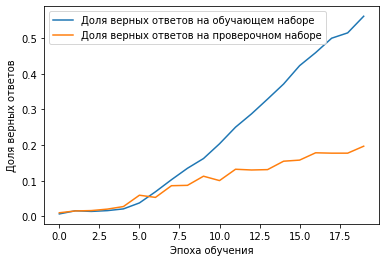

In [316]:
plt.plot(history_cnn.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history_cnn.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
# plt.plot(history_cnn.history['auc'], 
#          label='Доля верных ответов на обучающем наборе')
# plt.plot(history_cnn.history['val_auc'], 
#          label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [317]:
test_sequences = tokenizer.texts_to_sequences(train_text)
x_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_len)
test_y = train_y

In [318]:
test_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [319]:
model_cnn.load_weights(model_cnn_save_path)
model_cnn.evaluate(x_test, test_y, verbose=1)

102/102 [==============================] - 2s 21ms/step - loss: 1.9668 - accuracy: 0.5229 - auc_12: 0.9697


[1.96682870388031, 0.5229160189628601, 0.9696932435035706]

In [329]:
model_cnn.load_weights("./acc_50_auc_95.h5")

In [334]:
predicted_idx = model_cnn.predict(x_test[3:4]).argmax()
ref_ids[predicted_idx]

'05d4f6d7e4fe8c4b'